### Kaggle TGS Salt Identification Challenge
#### Segment salt deposits beneath the Earth's surface

#### U-net with simple Resnet Blocks in Keras & TensorFlow

* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.  Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     * For Lovasz loss need to cancel last sigmoid activation in the model
5. Add cross-validation over 5 folds and image augmentation
     

In [1]:
# Import all necessary libraries
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cv_total = 5 #number of cross-validation folds

version = 40
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v40.model
Unet_resnet_v40.csv


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

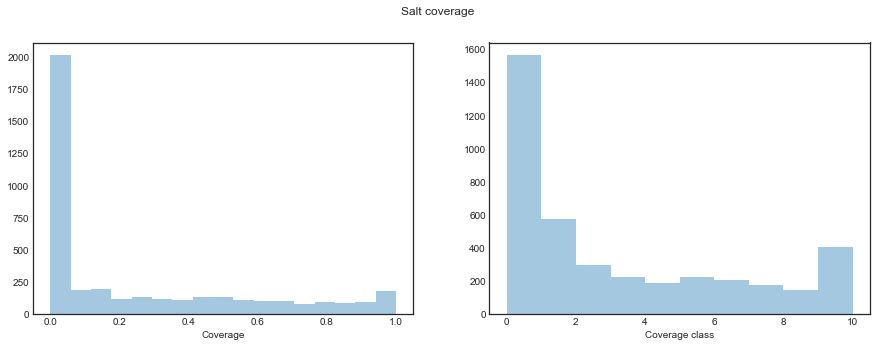

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

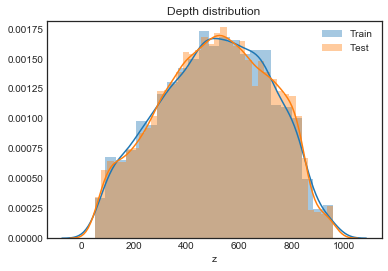

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [10]:
# Create train/validation split stratified by salt coverage
#
#ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
#    train_df.index.values,
#    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
#    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
#    train_df.coverage.values,
#    train_df.z.values,
#    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [11]:
#### Reference  from Heng's discussion
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984#382657
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)

train_df["coverage_class"] = train_df.masks.map(get_mask_type)

In [12]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=4444, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [13]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

(3198,) (802,)
train cv1, number of each mask class = 
 	[[1279.  192.   84.  372.  179.  407.  334.  351.]]
evaluate cv1, number of each mask class = 
 	 [[320.  48.  22.  93.  45. 102.  84.  88.]]


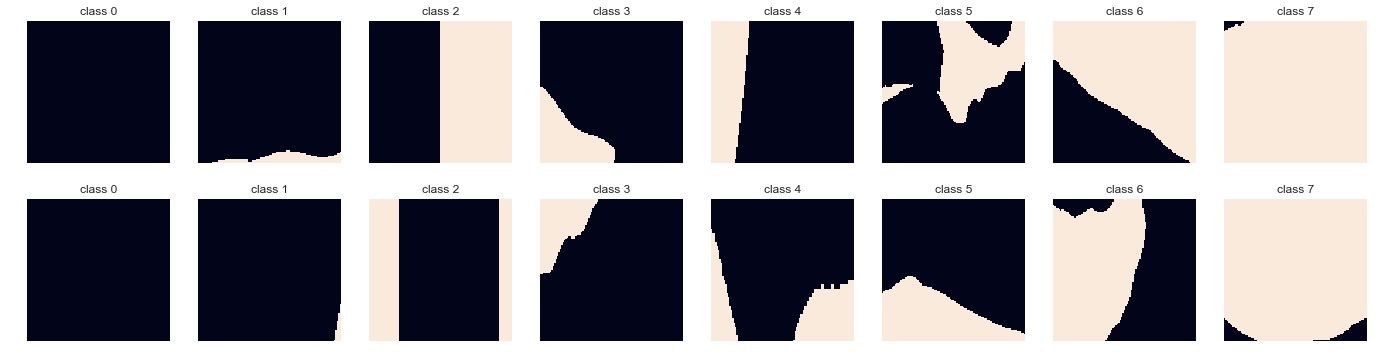

In [14]:
cv_index = 1
train_index = train_all[cv_index-1]
evaluate_index = evaluate_all[cv_index-1]

print(train_index.shape,evaluate_index.shape)
histall = histcoverage(train_df.coverage_class[train_index].values)
print(f'train cv{cv_index}, number of each mask class = \n \t{histall}')
histall_test = histcoverage(train_df.coverage_class[evaluate_index].values)
print(f'evaluate cv{cv_index}, number of each mask class = \n \t {histall_test}')

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(24, 6), sharex=True, sharey=True)

# show mask class example
for c in range(8):
    j= 0
    for i in train_index:
        if train_df.coverage_class[i] == c:
            axes[j,c].imshow(np.array(train_df.masks[i])  )
            axes[j,c].set_axis_off()
            axes[j,c].set_title(f'class {c}')
            j += 1
            if(j>=2):
                break

In [15]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [16]:
# Build U-Net CNN model (# Build U-Net CNN model)

def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [17]:
def get_iou_vector(A, B):

    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.0], tf.float64)

In [18]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.add(tf.nn.elu(errors_sorted),1.), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [19]:
def build_compile_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)

    model1 = Model(input_layer, output_layer)

    c = optimizers.adam(lr = lr)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    return model1

In [20]:
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [37]:
# Train augmentation

from imgaug import augmenters as iaa

def do_augmentation(seq_det, X_train, y_train):
    # Move from 0-1 float to uint8 format (needed for most imgaug operators)
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    # Do augmentation
    X_train_aug = seq_det.augment_images(X_train_aug)
    # Back to 0-1 float range
    X_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug]

    # Move from 0-1 float to uint8 format (needed for imgaug)
    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    # Do augmentation
    y_train_aug = seq_det.augment_images(y_train_aug)
    # Make sure we only have 2 values for mask augmented
    y_train_aug = [np.where(x[:,:,:] > 0, 255, 0) for x in y_train_aug]
    # Back to 0-1 float range
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    return np.array(X_train_aug), np.array(y_train_aug)

import imgaug as ia
from imgaug import augmenters as iaa
#sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip
    iaa.OneOf([
        iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Noop(),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.Noop(),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
        iaa.Noop(),
        #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02*255)),
        iaa.Noop(),
        iaa.Multiply((0.8, 1.2)),
        iaa.Noop(),
        #iaa.Add((-25, 25)),
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10),translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0)),
        iaa.Noop(),
        iaa.CropAndPad(percent=(-0.15, 0.15),pad_mode=ia.ALL,pad_cval=(0, 255))
    ]),    
    # More as you want ...
],random_order=True)
seq_det = seq.to_deterministic()

In [38]:
# Return augmented images/masks arrays of batch size
def generator(features, labels, batch_size, seq):
    # create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, features.shape[1], features.shape[2], features.shape[3]))
    batch_labels = np.zeros((batch_size, labels.shape[1], labels.shape[2], labels.shape[3]))

    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
        # Perform the exactly the same augmentation for X and y
        seq_det = seq.to_deterministic()
        random_augmented_images, random_augmented_labels = do_augmentation(seq_det, features[indexes], labels[indexes])
        batch_features[:,:,:,:] = random_augmented_images[:,:,:,:]
        batch_labels[:,:,:,:] = random_augmented_labels[:,:,:,:]

        yield batch_features, batch_labels

In [ ]:
ious = [0] * cv_total
ious2 = [0] * cv_total

############################################
 Unet_resnet_v40_cv1
Unet_resnet_v40_cv1_Step1a.model
Epoch 1/250
 - 51s - loss: 0.4449 - my_iou_metric: 0.1912 - val_loss: 2.2872 - val_my_iou_metric: 0.0076

Epoch 00001: val_my_iou_metric improved from -inf to 0.00761, saving model to Unet_resnet_v40_cv1_Step1a.model
Epoch 2/250
 - 26s - loss: 0.3278 - my_iou_metric: 0.4838 - val_loss: 0.6231 - val_my_iou_metric: 0.2299

Epoch 00002: val_my_iou_metric improved from 0.00761 to 0.22993, saving model to Unet_resnet_v40_cv1_Step1a.model
Epoch 3/250
 - 30s - loss: 0.2907 - my_iou_metric: 0.5237 - val_loss: 0.9794 - val_my_iou_metric: 0.1940

Epoch 00003: val_my_iou_metric did not improve from 0.22993
Epoch 4/250
 - 29s - loss: 0.2684 - my_iou_metric: 0.5316 - val_loss: 0.5174 - val_my_iou_metric: 0.3565

Epoch 00004: val_my_iou_metric improved from 0.22993 to 0.35648, saving model to Unet_resnet_v40_cv1_Step1a.model
Epoch 5/250
 - 31s - loss: 0.2525 - my_iou_metric: 0.5544 - val_loss: 0.3750 -

Epoch 00092: val_my_iou_metric did not improve from 0.75923
Epoch 93/250
 - 29s - loss: 0.0970 - my_iou_metric: 0.7574 - val_loss: 0.2246 - val_my_iou_metric: 0.6990

Epoch 00093: val_my_iou_metric did not improve from 0.75923
Epoch 94/250
 - 30s - loss: 0.1093 - my_iou_metric: 0.7598 - val_loss: 0.1994 - val_my_iou_metric: 0.7069

Epoch 00094: val_my_iou_metric did not improve from 0.75923
Epoch 95/250
 - 29s - loss: 0.0947 - my_iou_metric: 0.7720 - val_loss: 0.1774 - val_my_iou_metric: 0.7522

Epoch 00095: val_my_iou_metric did not improve from 0.75923
Epoch 96/250
 - 30s - loss: 0.1010 - my_iou_metric: 0.7524 - val_loss: 0.2267 - val_my_iou_metric: 0.7465

Epoch 00096: val_my_iou_metric did not improve from 0.75923
Epoch 97/250
 - 30s - loss: 0.0953 - my_iou_metric: 0.7685 - val_loss: 0.1691 - val_my_iou_metric: 0.7637

Epoch 00097: val_my_iou_metric improved from 0.75923 to 0.76372, saving model to Unet_resnet_v40_cv1_Step1a.model
Epoch 98/250
 - 30s - loss: 0.0993 - my_iou_metric:


Epoch 00140: val_my_iou_metric did not improve from 0.77618
Epoch 141/250
 - 30s - loss: 0.0854 - my_iou_metric: 0.7763 - val_loss: 0.1864 - val_my_iou_metric: 0.7313

Epoch 00141: val_my_iou_metric did not improve from 0.77618
Epoch 142/250
 - 30s - loss: 0.0763 - my_iou_metric: 0.7813 - val_loss: 0.1736 - val_my_iou_metric: 0.7581

Epoch 00142: val_my_iou_metric did not improve from 0.77618
Epoch 143/250
 - 29s - loss: 0.0777 - my_iou_metric: 0.7865 - val_loss: 0.1894 - val_my_iou_metric: 0.7478

Epoch 00143: val_my_iou_metric did not improve from 0.77618
Epoch 144/250
 - 29s - loss: 0.0765 - my_iou_metric: 0.7875 - val_loss: 0.1970 - val_my_iou_metric: 0.7317

Epoch 00144: val_my_iou_metric did not improve from 0.77618
Epoch 145/250
 - 30s - loss: 0.0818 - my_iou_metric: 0.7786 - val_loss: 0.2346 - val_my_iou_metric: 0.7534

Epoch 00145: val_my_iou_metric did not improve from 0.77618
Epoch 146/250
 - 30s - loss: 0.0790 - my_iou_metric: 0.7912 - val_loss: 0.2137 - val_my_iou_metric:


Epoch 00188: val_my_iou_metric did not improve from 0.78392
Epoch 189/250
 - 29s - loss: 0.0693 - my_iou_metric: 0.8070 - val_loss: 0.1649 - val_my_iou_metric: 0.7651

Epoch 00189: val_my_iou_metric did not improve from 0.78392
Epoch 190/250
 - 29s - loss: 0.0745 - my_iou_metric: 0.7960 - val_loss: 0.1832 - val_my_iou_metric: 0.7676

Epoch 00190: val_my_iou_metric did not improve from 0.78392
Epoch 191/250
 - 30s - loss: 0.0733 - my_iou_metric: 0.8041 - val_loss: 0.1757 - val_my_iou_metric: 0.7792

Epoch 00191: val_my_iou_metric did not improve from 0.78392
Epoch 192/250
 - 30s - loss: 0.0679 - my_iou_metric: 0.8101 - val_loss: 0.1978 - val_my_iou_metric: 0.7676

Epoch 00192: val_my_iou_metric did not improve from 0.78392
Epoch 193/250
 - 28s - loss: 0.0716 - my_iou_metric: 0.7986 - val_loss: 0.2060 - val_my_iou_metric: 0.7671

Epoch 00193: val_my_iou_metric did not improve from 0.78392
Epoch 194/250
 - 29s - loss: 0.0718 - my_iou_metric: 0.8047 - val_loss: 0.1887 - val_my_iou_metric:

 - 29s - loss: 0.0656 - my_iou_metric: 0.8128 - val_loss: 0.2678 - val_my_iou_metric: 0.7448

Epoch 00237: val_my_iou_metric did not improve from 0.78716
Epoch 238/250
 - 30s - loss: 0.0649 - my_iou_metric: 0.8133 - val_loss: 0.1850 - val_my_iou_metric: 0.7828

Epoch 00238: val_my_iou_metric did not improve from 0.78716
Epoch 239/250
 - 32s - loss: 0.0587 - my_iou_metric: 0.8196 - val_loss: 0.2134 - val_my_iou_metric: 0.7655

Epoch 00239: val_my_iou_metric did not improve from 0.78716
Epoch 240/250
 - 31s - loss: 0.0639 - my_iou_metric: 0.8100 - val_loss: 0.2208 - val_my_iou_metric: 0.7825

Epoch 00240: val_my_iou_metric did not improve from 0.78716
Epoch 241/250
 - 31s - loss: 0.0617 - my_iou_metric: 0.8211 - val_loss: 0.2677 - val_my_iou_metric: 0.6152

Epoch 00241: val_my_iou_metric did not improve from 0.78716
Epoch 242/250
 - 29s - loss: 0.0658 - my_iou_metric: 0.8153 - val_loss: 0.2057 - val_my_iou_metric: 0.7803

Epoch 00242: val_my_iou_metric did not improve from 0.78716
Epoch 


Epoch 00032: val_my_iou_metric_2 did not improve from 0.81746
Epoch 33/200
 - 81s - loss: 0.5694 - my_iou_metric_2: 0.8483 - val_loss: 0.9904 - val_my_iou_metric_2: 0.8066

Epoch 00033: val_my_iou_metric_2 did not improve from 0.81746
Epoch 34/200
 - 82s - loss: 0.5790 - my_iou_metric_2: 0.8483 - val_loss: 0.9525 - val_my_iou_metric_2: 0.8072

Epoch 00034: val_my_iou_metric_2 did not improve from 0.81746
Epoch 35/200
 - 83s - loss: 0.5523 - my_iou_metric_2: 0.8553 - val_loss: 0.9661 - val_my_iou_metric_2: 0.8019

Epoch 00035: val_my_iou_metric_2 did not improve from 0.81746
Epoch 36/200
 - 82s - loss: 0.5744 - my_iou_metric_2: 0.8448 - val_loss: 0.9599 - val_my_iou_metric_2: 0.8012

Epoch 00036: val_my_iou_metric_2 did not improve from 0.81746
Epoch 37/200
 - 82s - loss: 0.5780 - my_iou_metric_2: 0.8452 - val_loss: 0.9585 - val_my_iou_metric_2: 0.8046

Epoch 00037: val_my_iou_metric_2 did not improve from 0.81746
Epoch 38/200
 - 81s - loss: 0.5601 - my_iou_metric_2: 0.8504 - val_loss:


Epoch 00126: val_my_iou_metric_2 did not improve from 0.81883
Epoch 127/200
 - 81s - loss: 0.4755 - my_iou_metric_2: 0.8668 - val_loss: 1.0177 - val_my_iou_metric_2: 0.8032

Epoch 00127: val_my_iou_metric_2 did not improve from 0.81883
Epoch 128/200
 - 81s - loss: 0.4726 - my_iou_metric_2: 0.8654 - val_loss: 0.9708 - val_my_iou_metric_2: 0.8103

Epoch 00128: val_my_iou_metric_2 did not improve from 0.81883
Epoch 129/200
 - 81s - loss: 0.4778 - my_iou_metric_2: 0.8664 - val_loss: 0.9463 - val_my_iou_metric_2: 0.8178

Epoch 00129: val_my_iou_metric_2 did not improve from 0.81883
Epoch 130/200
 - 82s - loss: 0.4930 - my_iou_metric_2: 0.8635 - val_loss: 1.0013 - val_my_iou_metric_2: 0.8133

Epoch 00130: val_my_iou_metric_2 did not improve from 0.81883
Epoch 131/200
 - 80s - loss: 0.4445 - my_iou_metric_2: 0.8766 - val_loss: 0.9936 - val_my_iou_metric_2: 0.8110

Epoch 00131: val_my_iou_metric_2 did not improve from 0.81883
Epoch 132/200
 - 80s - loss: 0.4843 - my_iou_metric_2: 0.8639 - val


Epoch 00173: val_my_iou_metric_2 did not improve from 0.82007
Epoch 174/200
 - 81s - loss: 0.4581 - my_iou_metric_2: 0.8704 - val_loss: 0.9558 - val_my_iou_metric_2: 0.8176

Epoch 00174: val_my_iou_metric_2 did not improve from 0.82007
Epoch 175/200
 - 81s - loss: 0.4665 - my_iou_metric_2: 0.8681 - val_loss: 0.9879 - val_my_iou_metric_2: 0.8029

Epoch 00175: val_my_iou_metric_2 did not improve from 0.82007
Epoch 176/200
 - 82s - loss: 0.4516 - my_iou_metric_2: 0.8751 - val_loss: 0.9947 - val_my_iou_metric_2: 0.8130

Epoch 00176: val_my_iou_metric_2 did not improve from 0.82007
Epoch 177/200
 - 82s - loss: 0.4322 - my_iou_metric_2: 0.8808 - val_loss: 1.1662 - val_my_iou_metric_2: 0.8031

Epoch 00177: val_my_iou_metric_2 did not improve from 0.82007
Epoch 178/200
 - 81s - loss: 0.4567 - my_iou_metric_2: 0.8725 - val_loss: 0.9825 - val_my_iou_metric_2: 0.8127

Epoch 00178: val_my_iou_metric_2 did not improve from 0.82007
Epoch 179/200
 - 81s - loss: 0.4432 - my_iou_metric_2: 0.8773 - val


Epoch 00018: val_my_iou_metric improved from 0.68577 to 0.68764, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 19/250
 - 31s - loss: 0.1682 - my_iou_metric: 0.6813 - val_loss: 0.1639 - val_my_iou_metric: 0.6970

Epoch 00019: val_my_iou_metric improved from 0.68764 to 0.69700, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 20/250
 - 30s - loss: 0.1640 - my_iou_metric: 0.6684 - val_loss: 0.1644 - val_my_iou_metric: 0.7276

Epoch 00020: val_my_iou_metric improved from 0.69700 to 0.72759, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 21/250
 - 28s - loss: 0.1544 - my_iou_metric: 0.6903 - val_loss: 0.1869 - val_my_iou_metric: 0.7049

Epoch 00021: val_my_iou_metric did not improve from 0.72759
Epoch 22/250
 - 30s - loss: 0.1654 - my_iou_metric: 0.6760 - val_loss: 0.1626 - val_my_iou_metric: 0.6853

Epoch 00022: val_my_iou_metric did not improve from 0.72759
Epoch 23/250
 - 30s - loss: 0.1640 - my_iou_metric: 0.6811 - val_loss: 0.1548 - val_my_iou_metric: 0.7291

Ep


Epoch 00063: val_my_iou_metric did not improve from 0.78377
Epoch 64/250
 - 30s - loss: 0.1143 - my_iou_metric: 0.7498 - val_loss: 0.1654 - val_my_iou_metric: 0.7727

Epoch 00064: val_my_iou_metric did not improve from 0.78377
Epoch 65/250
 - 32s - loss: 0.1110 - my_iou_metric: 0.7460 - val_loss: 0.1447 - val_my_iou_metric: 0.7727

Epoch 00065: val_my_iou_metric did not improve from 0.78377
Epoch 66/250
 - 30s - loss: 0.1140 - my_iou_metric: 0.7440 - val_loss: 0.1559 - val_my_iou_metric: 0.7831

Epoch 00066: val_my_iou_metric did not improve from 0.78377
Epoch 67/250
 - 31s - loss: 0.1075 - my_iou_metric: 0.7504 - val_loss: 0.1611 - val_my_iou_metric: 0.7591

Epoch 00067: val_my_iou_metric did not improve from 0.78377
Epoch 68/250
 - 31s - loss: 0.1097 - my_iou_metric: 0.7590 - val_loss: 0.1540 - val_my_iou_metric: 0.7944

Epoch 00068: val_my_iou_metric improved from 0.78377 to 0.79438, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 69/250
 - 29s - loss: 0.1086 - my_iou_metric

KeyboardInterrupt: 

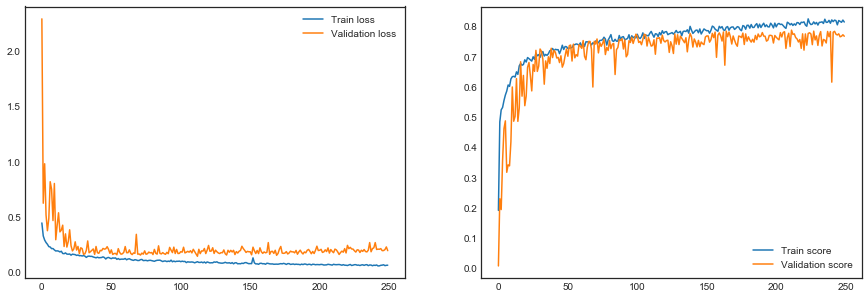

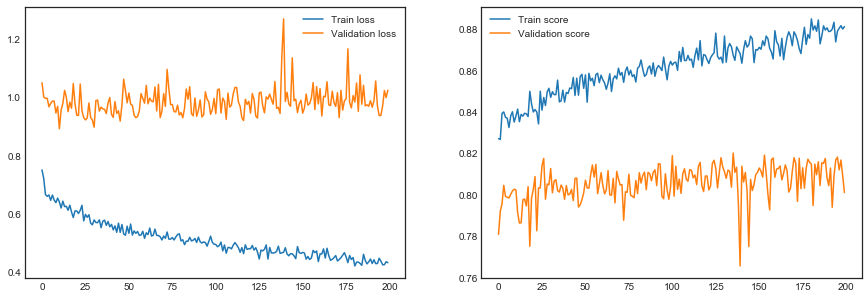

In [39]:
# training cv=1

t_start = time.time()

for cv_index in range(cv_total):
    t1 = time.time()
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    #save_model_name_prev = f'Unet_resnet_v36_cv{cv_index+1}' + '.model'
    #print(save_model_name_prev)
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    #---------------- Step 1 - BCE loss -------------------------
    save_model_name = basic_name + '_Step1a.model'
    print(save_model_name)
    
    #model = load_model(save_model_name_prev,custom_objects={'my_iou_metric': my_iou_metric})
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)
    model = Model(input_layer, output_layer)
    
    c = optimizers.adam(lr = 0.001)
    model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    #model.load_weights(save_model_name_prev)

    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max',save_best_only=True, verbose=1)
    #reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',
    #                               factor=0.5, patience=25, min_lr=0.0001, verbose=1)

    epochs = 250  
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] #,reduce_lr
                             )
    plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(np.squeeze(y_valid), np.squeeze(preds_valid > 0.5))
    print(f"cv {cv_index} ious = {ious[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
    #---------------- Step 2 - Lovasz Loss -------------------------
    input_x = model.layers[0].input
    output_layer = model.layers[-1].input #need to cancel last sigmoid activation for Lovasz Loss
    model = Model(input_x, output_layer)
    c = optimizers.adam(lr = 0.0005)
    
    # lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
    # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    model.load_weights(save_model_name)
    
    save_model_name=basic_name + '_Step2a.model'
    print(save_model_name)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2',
                                       mode = 'max', save_best_only=True, verbose=1)
    
    epochs = 200
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history2 = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] 
                             )
    plot_history(history2,'my_iou_metric_2')
    
    model.load_weights(save_model_name)
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious2[cv_index] = get_iou_vector(np.squeeze(y_valid),np.squeeze(preds_valid > 0.0))
    print(f"cv {cv_index} ious2 = {ious2[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
t_end = time.time()
print(f"Usedtime = {t_end-t_start} s")

In [40]:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")
    
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious2 = {ious2[cv_index]}")

cv 0 ious = 0.7885286783042393
cv 1 ious = 0
cv 2 ious = 0
cv 3 ious = 0
cv 4 ious = 0
cv 0 ious2 = 0.8200748129675811
cv 1 ious2 = 0
cv 2 ious2 = 0
cv 3 ious2 = 0
cv 4 ious2 = 0


1
############################################
 Unet_resnet_v40_cv2
Unet_resnet_v40_cv2_Step1a.model
Epoch 1/250
 - 111s - loss: 0.5027 - my_iou_metric: 0.2337 - val_loss: 3.8436 - val_my_iou_metric: 0.3858

Epoch 00001: val_my_iou_metric improved from -inf to 0.38577, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 2/250
 - 30s - loss: 0.3406 - my_iou_metric: 0.4947 - val_loss: 0.6204 - val_my_iou_metric: 0.4079

Epoch 00002: val_my_iou_metric improved from 0.38577 to 0.40787, saving model to Unet_resnet_v40_cv2_Step1a.model
Epoch 3/250
 - 35s - loss: 0.3124 - my_iou_metric: 0.4966 - val_loss: 0.6533 - val_my_iou_metric: 0.2436

Epoch 00003: val_my_iou_metric did not improve from 0.40787
Epoch 4/250
 - 33s - loss: 0.2797 - my_iou_metric: 0.5159 - val_loss: 0.4274 - val_my_iou_metric: 0.3878

Epoch 00004: val_my_iou_metric did not improve from 0.40787
Epoch 5/250
 - 33s - loss: 0.2618 - my_iou_metric: 0.5696 - val_loss: 0.3245 - val_my_iou_metric: 0.4989

Epoch 00005: val_my_iou

Epoch 00091: val_my_iou_metric did not improve from 0.80037
Epoch 92/250
 - 32s - loss: 0.0982 - my_iou_metric: 0.7664 - val_loss: 0.1566 - val_my_iou_metric: 0.7878

Epoch 00092: val_my_iou_metric did not improve from 0.80037
Epoch 93/250
 - 33s - loss: 0.1008 - my_iou_metric: 0.7535 - val_loss: 0.1356 - val_my_iou_metric: 0.7844

Epoch 00093: val_my_iou_metric did not improve from 0.80037
Epoch 94/250
 - 33s - loss: 0.1033 - my_iou_metric: 0.7508 - val_loss: 0.1411 - val_my_iou_metric: 0.7720

Epoch 00094: val_my_iou_metric did not improve from 0.80037
Epoch 95/250
 - 32s - loss: 0.1026 - my_iou_metric: 0.7650 - val_loss: 0.1695 - val_my_iou_metric: 0.7717

Epoch 00095: val_my_iou_metric did not improve from 0.80037
Epoch 96/250
 - 32s - loss: 0.0979 - my_iou_metric: 0.7537 - val_loss: 0.1826 - val_my_iou_metric: 0.7910

Epoch 00096: val_my_iou_metric did not improve from 0.80037
Epoch 97/250
 - 33s - loss: 0.0899 - my_iou_metric: 0.7643 - val_loss: 0.1473 - val_my_iou_metric: 0.7989


Epoch 00140: val_my_iou_metric did not improve from 0.80262
Epoch 141/250
 - 33s - loss: 0.0885 - my_iou_metric: 0.7742 - val_loss: 0.2052 - val_my_iou_metric: 0.7820

Epoch 00141: val_my_iou_metric did not improve from 0.80262
Epoch 142/250
 - 32s - loss: 0.0771 - my_iou_metric: 0.7853 - val_loss: 0.1512 - val_my_iou_metric: 0.7940

Epoch 00142: val_my_iou_metric did not improve from 0.80262
Epoch 143/250
 - 31s - loss: 0.0775 - my_iou_metric: 0.7875 - val_loss: 0.1428 - val_my_iou_metric: 0.7589

Epoch 00143: val_my_iou_metric did not improve from 0.80262
Epoch 144/250
 - 32s - loss: 0.0795 - my_iou_metric: 0.7841 - val_loss: 0.1574 - val_my_iou_metric: 0.7787

Epoch 00144: val_my_iou_metric did not improve from 0.80262
Epoch 145/250
 - 34s - loss: 0.0793 - my_iou_metric: 0.7841 - val_loss: 0.1745 - val_my_iou_metric: 0.7659

Epoch 00145: val_my_iou_metric did not improve from 0.80262
Epoch 146/250
 - 32s - loss: 0.0824 - my_iou_metric: 0.7808 - val_loss: 0.1786 - val_my_iou_metric:


Epoch 00237: val_my_iou_metric did not improve from 0.80899
Epoch 238/250
 - 33s - loss: 0.0596 - my_iou_metric: 0.8075 - val_loss: 0.1879 - val_my_iou_metric: 0.7846

Epoch 00238: val_my_iou_metric did not improve from 0.80899
Epoch 239/250
 - 32s - loss: 0.0654 - my_iou_metric: 0.8080 - val_loss: 0.1699 - val_my_iou_metric: 0.7607

Epoch 00239: val_my_iou_metric did not improve from 0.80899
Epoch 240/250
 - 34s - loss: 0.0620 - my_iou_metric: 0.8163 - val_loss: 0.1635 - val_my_iou_metric: 0.7999

Epoch 00240: val_my_iou_metric did not improve from 0.80899
Epoch 241/250
 - 32s - loss: 0.0600 - my_iou_metric: 0.8171 - val_loss: 0.2228 - val_my_iou_metric: 0.7678

Epoch 00241: val_my_iou_metric did not improve from 0.80899
Epoch 242/250
 - 32s - loss: 0.0634 - my_iou_metric: 0.8026 - val_loss: 0.1738 - val_my_iou_metric: 0.8020

Epoch 00242: val_my_iou_metric did not improve from 0.80899
Epoch 243/250
 - 32s - loss: 0.0573 - my_iou_metric: 0.8198 - val_loss: 0.1812 - val_my_iou_metric:


Epoch 00031: val_my_iou_metric_2 did not improve from 0.82347
Epoch 32/200
 - 82s - loss: 0.6106 - my_iou_metric_2: 0.8394 - val_loss: 0.8554 - val_my_iou_metric_2: 0.8139

Epoch 00032: val_my_iou_metric_2 did not improve from 0.82347
Epoch 33/200
 - 84s - loss: 0.6135 - my_iou_metric_2: 0.8370 - val_loss: 0.8477 - val_my_iou_metric_2: 0.8157

Epoch 00033: val_my_iou_metric_2 did not improve from 0.82347
Epoch 34/200
 - 82s - loss: 0.5975 - my_iou_metric_2: 0.8402 - val_loss: 0.8333 - val_my_iou_metric_2: 0.8160

Epoch 00034: val_my_iou_metric_2 did not improve from 0.82347
Epoch 35/200
 - 81s - loss: 0.5952 - my_iou_metric_2: 0.8418 - val_loss: 0.8456 - val_my_iou_metric_2: 0.8130

Epoch 00035: val_my_iou_metric_2 did not improve from 0.82347
Epoch 36/200
 - 81s - loss: 0.5868 - my_iou_metric_2: 0.8438 - val_loss: 0.8871 - val_my_iou_metric_2: 0.8085

Epoch 00036: val_my_iou_metric_2 did not improve from 0.82347
Epoch 37/200
 - 81s - loss: 0.6099 - my_iou_metric_2: 0.8371 - val_loss:


Epoch 00078: val_my_iou_metric_2 improved from 0.82609 to 0.82772, saving model to Unet_resnet_v40_cv2_Step2a.model
Epoch 79/200
 - 84s - loss: 0.5259 - my_iou_metric_2: 0.8570 - val_loss: 0.8900 - val_my_iou_metric_2: 0.8181

Epoch 00079: val_my_iou_metric_2 did not improve from 0.82772
Epoch 80/200
 - 84s - loss: 0.5076 - my_iou_metric_2: 0.8593 - val_loss: 0.8863 - val_my_iou_metric_2: 0.8102

Epoch 00080: val_my_iou_metric_2 did not improve from 0.82772
Epoch 81/200
 - 81s - loss: 0.5376 - my_iou_metric_2: 0.8522 - val_loss: 0.8744 - val_my_iou_metric_2: 0.8150

Epoch 00081: val_my_iou_metric_2 did not improve from 0.82772
Epoch 82/200
 - 82s - loss: 0.5479 - my_iou_metric_2: 0.8504 - val_loss: 0.8915 - val_my_iou_metric_2: 0.8177

Epoch 00082: val_my_iou_metric_2 did not improve from 0.82772
Epoch 83/200
 - 81s - loss: 0.5423 - my_iou_metric_2: 0.8531 - val_loss: 0.8805 - val_my_iou_metric_2: 0.8116

Epoch 00083: val_my_iou_metric_2 did not improve from 0.82772
Epoch 84/200
 - 81


Epoch 00125: val_my_iou_metric_2 did not improve from 0.82772
Epoch 126/200
 - 90s - loss: 0.4923 - my_iou_metric_2: 0.8617 - val_loss: 0.8550 - val_my_iou_metric_2: 0.8115

Epoch 00126: val_my_iou_metric_2 did not improve from 0.82772
Epoch 127/200
 - 86s - loss: 0.5132 - my_iou_metric_2: 0.8547 - val_loss: 0.8857 - val_my_iou_metric_2: 0.8225

Epoch 00127: val_my_iou_metric_2 did not improve from 0.82772
Epoch 128/200
 - 88s - loss: 0.4982 - my_iou_metric_2: 0.8604 - val_loss: 0.8530 - val_my_iou_metric_2: 0.8208

Epoch 00128: val_my_iou_metric_2 did not improve from 0.82772
Epoch 129/200
 - 89s - loss: 0.4795 - my_iou_metric_2: 0.8687 - val_loss: 0.7992 - val_my_iou_metric_2: 0.8232

Epoch 00129: val_my_iou_metric_2 did not improve from 0.82772
Epoch 130/200
 - 87s - loss: 0.4847 - my_iou_metric_2: 0.8625 - val_loss: 0.8503 - val_my_iou_metric_2: 0.8165

Epoch 00130: val_my_iou_metric_2 did not improve from 0.82772
Epoch 131/200
 - 89s - loss: 0.4968 - my_iou_metric_2: 0.8625 - val


Epoch 00172: val_my_iou_metric_2 did not improve from 0.82996
Epoch 173/200
 - 82s - loss: 0.4767 - my_iou_metric_2: 0.8714 - val_loss: 0.8265 - val_my_iou_metric_2: 0.8301

Epoch 00173: val_my_iou_metric_2 improved from 0.82996 to 0.83009, saving model to Unet_resnet_v40_cv2_Step2a.model
Epoch 174/200
 - 82s - loss: 0.4571 - my_iou_metric_2: 0.8727 - val_loss: 0.8817 - val_my_iou_metric_2: 0.8232

Epoch 00174: val_my_iou_metric_2 did not improve from 0.83009
Epoch 175/200
 - 83s - loss: 0.4496 - my_iou_metric_2: 0.8758 - val_loss: 0.8737 - val_my_iou_metric_2: 0.8185

Epoch 00175: val_my_iou_metric_2 did not improve from 0.83009
Epoch 176/200
 - 82s - loss: 0.4595 - my_iou_metric_2: 0.8719 - val_loss: 0.9035 - val_my_iou_metric_2: 0.8116

Epoch 00176: val_my_iou_metric_2 did not improve from 0.83009
Epoch 177/200
 - 82s - loss: 0.4507 - my_iou_metric_2: 0.8721 - val_loss: 0.8459 - val_my_iou_metric_2: 0.8237

Epoch 00177: val_my_iou_metric_2 did not improve from 0.83009
Epoch 178/200


Epoch 00062: val_my_iou_metric did not improve from 0.76292
Epoch 63/250
 - 33s - loss: 0.1156 - my_iou_metric: 0.7376 - val_loss: 0.1552 - val_my_iou_metric: 0.7395

Epoch 00063: val_my_iou_metric did not improve from 0.76292
Epoch 64/250
 - 35s - loss: 0.1194 - my_iou_metric: 0.7414 - val_loss: 0.1292 - val_my_iou_metric: 0.7571

Epoch 00064: val_my_iou_metric did not improve from 0.76292
Epoch 65/250
 - 34s - loss: 0.1171 - my_iou_metric: 0.7378 - val_loss: 0.1619 - val_my_iou_metric: 0.7479

Epoch 00065: val_my_iou_metric did not improve from 0.76292
Epoch 66/250
 - 33s - loss: 0.1160 - my_iou_metric: 0.7444 - val_loss: 0.1512 - val_my_iou_metric: 0.7548

Epoch 00066: val_my_iou_metric did not improve from 0.76292
Epoch 67/250
 - 34s - loss: 0.1121 - my_iou_metric: 0.7447 - val_loss: 0.1978 - val_my_iou_metric: 0.7211

Epoch 00067: val_my_iou_metric did not improve from 0.76292
Epoch 68/250
 - 32s - loss: 0.1095 - my_iou_metric: 0.7561 - val_loss: 0.1590 - val_my_iou_metric: 0.747


Epoch 00110: val_my_iou_metric did not improve from 0.77728
Epoch 111/250
 - 33s - loss: 0.0879 - my_iou_metric: 0.7676 - val_loss: 0.1823 - val_my_iou_metric: 0.7200

Epoch 00111: val_my_iou_metric did not improve from 0.77728
Epoch 112/250
 - 33s - loss: 0.0921 - my_iou_metric: 0.7636 - val_loss: 0.1561 - val_my_iou_metric: 0.7492

Epoch 00112: val_my_iou_metric did not improve from 0.77728
Epoch 113/250
 - 34s - loss: 0.0959 - my_iou_metric: 0.7714 - val_loss: 0.1473 - val_my_iou_metric: 0.7512

Epoch 00113: val_my_iou_metric did not improve from 0.77728
Epoch 114/250
 - 32s - loss: 0.0934 - my_iou_metric: 0.7671 - val_loss: 0.1287 - val_my_iou_metric: 0.7765

Epoch 00114: val_my_iou_metric did not improve from 0.77728
Epoch 115/250
 - 33s - loss: 0.0835 - my_iou_metric: 0.7748 - val_loss: 0.1534 - val_my_iou_metric: 0.7774

Epoch 00115: val_my_iou_metric improved from 0.77728 to 0.77740, saving model to Unet_resnet_v40_cv3_Step1a.model
Epoch 116/250
 - 34s - loss: 0.0934 - my_iou_


Epoch 00158: val_my_iou_metric did not improve from 0.79001
Epoch 159/250
 - 32s - loss: 0.0826 - my_iou_metric: 0.7807 - val_loss: 0.1682 - val_my_iou_metric: 0.7704

Epoch 00159: val_my_iou_metric did not improve from 0.79001
Epoch 160/250
 - 32s - loss: 0.0715 - my_iou_metric: 0.7913 - val_loss: 0.1443 - val_my_iou_metric: 0.7815

Epoch 00160: val_my_iou_metric did not improve from 0.79001
Epoch 161/250
 - 35s - loss: 0.0675 - my_iou_metric: 0.7981 - val_loss: 0.1705 - val_my_iou_metric: 0.7604

Epoch 00161: val_my_iou_metric did not improve from 0.79001
Epoch 162/250
 - 34s - loss: 0.0729 - my_iou_metric: 0.7884 - val_loss: 0.1340 - val_my_iou_metric: 0.7699

Epoch 00162: val_my_iou_metric did not improve from 0.79001
Epoch 163/250
 - 33s - loss: 0.0721 - my_iou_metric: 0.7935 - val_loss: 0.1587 - val_my_iou_metric: 0.7568

Epoch 00163: val_my_iou_metric did not improve from 0.79001
Epoch 164/250
 - 33s - loss: 0.0781 - my_iou_metric: 0.7926 - val_loss: 0.1764 - val_my_iou_metric:

Epoch 00003: val_my_iou_metric_2 improved from 0.78502 to 0.80462, saving model to Unet_resnet_v40_cv3_Step2a.model
Epoch 4/200
 - 82s - loss: 0.6961 - my_iou_metric_2: 0.8317 - val_loss: 0.9036 - val_my_iou_metric_2: 0.8020

Epoch 00004: val_my_iou_metric_2 did not improve from 0.80462
Epoch 5/200
 - 82s - loss: 0.6969 - my_iou_metric_2: 0.8282 - val_loss: 0.8904 - val_my_iou_metric_2: 0.7979

Epoch 00005: val_my_iou_metric_2 did not improve from 0.80462
Epoch 6/200
 - 82s - loss: 0.6776 - my_iou_metric_2: 0.8333 - val_loss: 0.9197 - val_my_iou_metric_2: 0.8051

Epoch 00006: val_my_iou_metric_2 improved from 0.80462 to 0.80512, saving model to Unet_resnet_v40_cv3_Step2a.model
Epoch 7/200
 - 81s - loss: 0.6742 - my_iou_metric_2: 0.8312 - val_loss: 0.8840 - val_my_iou_metric_2: 0.8065

Epoch 00007: val_my_iou_metric_2 improved from 0.80512 to 0.80649, saving model to Unet_resnet_v40_cv3_Step2a.model
Epoch 8/200
 - 81s - loss: 0.6792 - my_iou_metric_2: 0.8280 - val_loss: 0.8563 - val_my_


Epoch 00048: val_my_iou_metric_2 did not improve from 0.81998
Epoch 49/200
 - 85s - loss: 0.5527 - my_iou_metric_2: 0.8533 - val_loss: 0.8488 - val_my_iou_metric_2: 0.8082

Epoch 00049: val_my_iou_metric_2 did not improve from 0.81998
Epoch 50/200
 - 81s - loss: 0.5225 - my_iou_metric_2: 0.8614 - val_loss: 0.8460 - val_my_iou_metric_2: 0.8131

Epoch 00050: val_my_iou_metric_2 did not improve from 0.81998
Epoch 51/200
 - 82s - loss: 0.5692 - my_iou_metric_2: 0.8475 - val_loss: 0.8409 - val_my_iou_metric_2: 0.8067

Epoch 00051: val_my_iou_metric_2 did not improve from 0.81998
Epoch 52/200
 - 89s - loss: 0.5539 - my_iou_metric_2: 0.8510 - val_loss: 0.8557 - val_my_iou_metric_2: 0.8192

Epoch 00052: val_my_iou_metric_2 did not improve from 0.81998
Epoch 53/200
 - 83s - loss: 0.5531 - my_iou_metric_2: 0.8533 - val_loss: 0.8299 - val_my_iou_metric_2: 0.8050

Epoch 00053: val_my_iou_metric_2 did not improve from 0.81998
Epoch 54/200
 - 83s - loss: 0.5433 - my_iou_metric_2: 0.8565 - val_loss:


Epoch 00141: val_my_iou_metric_2 did not improve from 0.82647
Epoch 142/200
 - 82s - loss: 0.4830 - my_iou_metric_2: 0.8688 - val_loss: 0.8672 - val_my_iou_metric_2: 0.8155

Epoch 00142: val_my_iou_metric_2 did not improve from 0.82647
Epoch 143/200
 - 81s - loss: 0.4762 - my_iou_metric_2: 0.8669 - val_loss: 0.8326 - val_my_iou_metric_2: 0.8161

Epoch 00143: val_my_iou_metric_2 did not improve from 0.82647
Epoch 144/200
 - 82s - loss: 0.4589 - my_iou_metric_2: 0.8754 - val_loss: 0.8313 - val_my_iou_metric_2: 0.8227

Epoch 00144: val_my_iou_metric_2 did not improve from 0.82647
Epoch 145/200
 - 81s - loss: 0.4735 - my_iou_metric_2: 0.8691 - val_loss: 0.8893 - val_my_iou_metric_2: 0.8205

Epoch 00145: val_my_iou_metric_2 did not improve from 0.82647
Epoch 146/200
 - 82s - loss: 0.4575 - my_iou_metric_2: 0.8737 - val_loss: 0.9425 - val_my_iou_metric_2: 0.8171

Epoch 00146: val_my_iou_metric_2 did not improve from 0.82647
Epoch 147/200
 - 81s - loss: 0.4863 - my_iou_metric_2: 0.8659 - val

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-a586013a2467>", line 25, in <module>
    output_layer = build_model(input_layer, 16,0.5)
  File "<ipython-input-16-c34f476ca5b5>", line 5, in build_model
    conv1 = residual_block(conv1,start_neurons * 1)
  File "<ipython-input-15-e6fc349c44db>", line 15, in residual_block
    x = convolution_block(x, num_filters, (3,3), activation=False)
  File "<ipython-input-15-e6fc349c44db>", line 7, in convolution_block
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
  File "C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "C:\Users\AK\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 138, in build
    co

KeyboardInterrupt: 

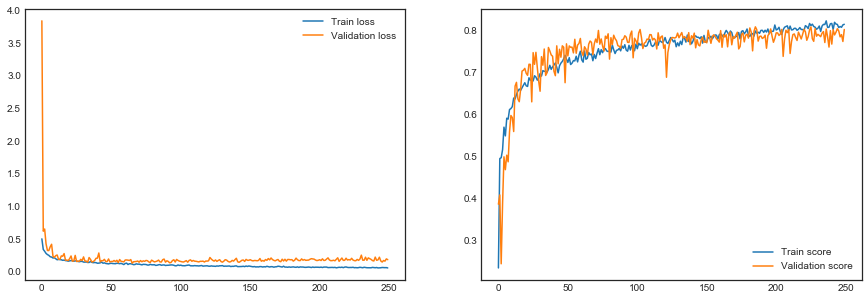

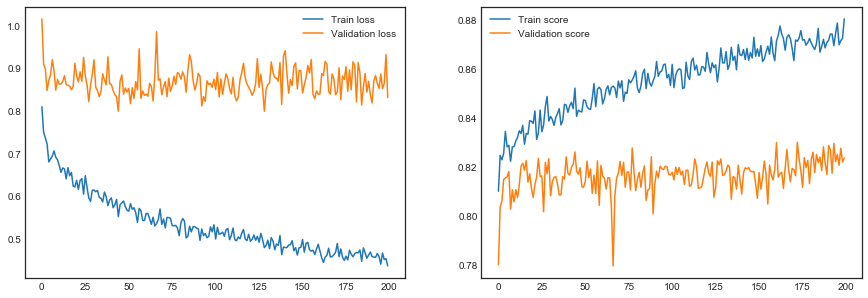

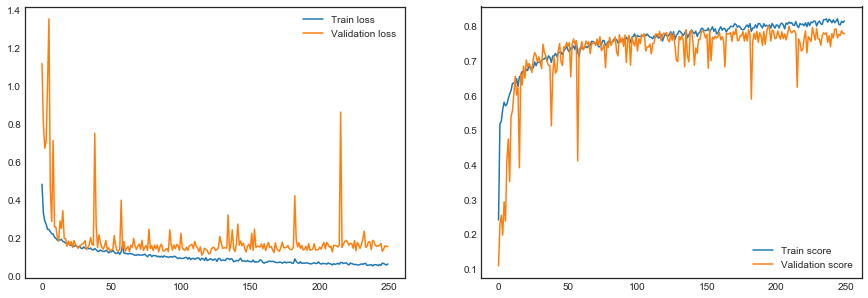

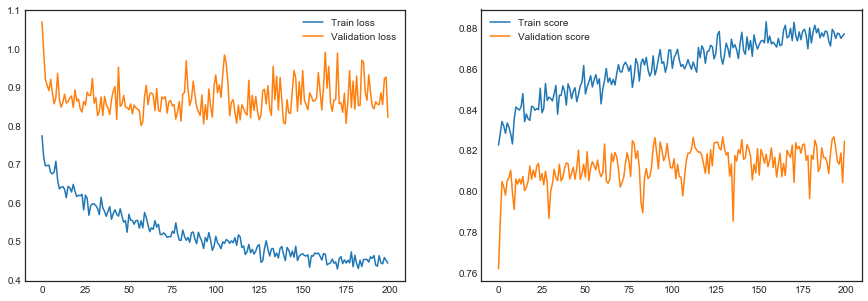

In [70]:
# training cv=[2,3]

t_start = time.time()

for cv_index in range(1,cv_total):
    print(cv_index)
    t1 = time.time()
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    #save_model_name_prev = f'Unet_resnet_v36_cv{cv_index+1}' + '.model'
    #print(save_model_name_prev)

    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    #---------------- Step 1 - BCE -------------------------
    save_model_name = basic_name + '_Step1a.model'
    print(save_model_name)
    
    #model = load_model(save_model_name_prev,custom_objects={'my_iou_metric': my_iou_metric})
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)
    model = Model(input_layer, output_layer)
    
    c = optimizers.adam(lr = 0.001)
    model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    #model.load_weights(save_model_name_prev)

    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max',save_best_only=True, verbose=1)
    #reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',
    #                               factor=0.5, patience=25, min_lr=0.0001, verbose=1)

    epochs = 250  
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] #,reduce_lr
                             )
    plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(np.squeeze(y_valid), np.squeeze(preds_valid > 0.5))
    print(f"cv {cv_index} ious = {ious[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
    #---------------- Step 2 - LL -------------------------
    input_x = model.layers[0].input
    output_layer = model.layers[-1].input #need to cancel last sigmoid activation for Lovasz Loss
    model = Model(input_x, output_layer)
    c = optimizers.adam(lr = 0.0005)
    
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    model.load_weights(save_model_name)
    
    save_model_name=basic_name + '_Step2a.model'
    print(save_model_name)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2',
                                       mode = 'max', save_best_only=True, verbose=1)
    
    epochs = 200
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history2 = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] 
                             )
    plot_history(history2,'my_iou_metric_2')
    
    model.load_weights(save_model_name)
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious2[cv_index] = get_iou_vector(np.squeeze(y_valid),np.squeeze(preds_valid > 0.0))
    print(f"cv {cv_index} ious2 = {ious2[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
t_end = time.time()
print(f"Usedtime = {t_end-t_start} s")

3
############################################
 Unet_resnet_v40_cv4
Unet_resnet_v40_cv4_Step1a.model
Epoch 1/150
 - 145s - loss: 0.6043 - my_iou_metric: 0.1427 - val_loss: 0.5171 - val_my_iou_metric: 0.1870

Epoch 00001: val_my_iou_metric improved from -inf to 0.18700, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 2/150
 - 30s - loss: 0.4309 - my_iou_metric: 0.3368 - val_loss: 0.5241 - val_my_iou_metric: 0.3970

Epoch 00002: val_my_iou_metric improved from 0.18700 to 0.39700, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 3/150
 - 36s - loss: 0.3434 - my_iou_metric: 0.4453 - val_loss: 0.4463 - val_my_iou_metric: 0.5459

Epoch 00003: val_my_iou_metric improved from 0.39700 to 0.54588, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 4/150
 - 34s - loss: 0.3011 - my_iou_metric: 0.5300 - val_loss: 0.3316 - val_my_iou_metric: 0.5434

Epoch 00004: val_my_iou_metric did not improve from 0.54588
Epoch 5/150
 - 34s - loss: 0.2711 - my_iou_metric: 0.5249 - val_loss: 0.492


Epoch 00046: val_my_iou_metric improved from 0.72888 to 0.73088, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 47/150
 - 35s - loss: 0.1378 - my_iou_metric: 0.7157 - val_loss: 0.1850 - val_my_iou_metric: 0.6863

Epoch 00047: val_my_iou_metric did not improve from 0.73088
Epoch 48/150
 - 35s - loss: 0.1356 - my_iou_metric: 0.7091 - val_loss: 0.1468 - val_my_iou_metric: 0.7266

Epoch 00048: val_my_iou_metric did not improve from 0.73088
Epoch 49/150
 - 35s - loss: 0.1358 - my_iou_metric: 0.7202 - val_loss: 0.1739 - val_my_iou_metric: 0.6981

Epoch 00049: val_my_iou_metric did not improve from 0.73088
Epoch 50/150
 - 34s - loss: 0.1278 - my_iou_metric: 0.7232 - val_loss: 0.1429 - val_my_iou_metric: 0.7325

Epoch 00050: val_my_iou_metric improved from 0.73088 to 0.73250, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 51/150
 - 35s - loss: 0.1308 - my_iou_metric: 0.7163 - val_loss: 0.1485 - val_my_iou_metric: 0.7425

Epoch 00051: val_my_iou_metric improved from 0.73250 to 

 - 34s - loss: 0.1031 - my_iou_metric: 0.7553 - val_loss: 0.1519 - val_my_iou_metric: 0.7661

Epoch 00094: val_my_iou_metric improved from 0.75975 to 0.76612, saving model to Unet_resnet_v40_cv4_Step1a.model
Epoch 95/150
 - 34s - loss: 0.1070 - my_iou_metric: 0.7600 - val_loss: 0.2182 - val_my_iou_metric: 0.6861

Epoch 00095: val_my_iou_metric did not improve from 0.76612
Epoch 96/150
 - 34s - loss: 0.1012 - my_iou_metric: 0.7544 - val_loss: 0.1607 - val_my_iou_metric: 0.7381

Epoch 00096: val_my_iou_metric did not improve from 0.76612
Epoch 97/150
 - 34s - loss: 0.1031 - my_iou_metric: 0.7578 - val_loss: 0.2083 - val_my_iou_metric: 0.7514

Epoch 00097: val_my_iou_metric did not improve from 0.76612
Epoch 98/150
 - 34s - loss: 0.1023 - my_iou_metric: 0.7470 - val_loss: 0.1697 - val_my_iou_metric: 0.7576

Epoch 00098: val_my_iou_metric did not improve from 0.76612
Epoch 99/150
 - 33s - loss: 0.1058 - my_iou_metric: 0.7545 - val_loss: 0.1841 - val_my_iou_metric: 0.7304

Epoch 00099: val_


Epoch 00141: val_my_iou_metric did not improve from 0.77525
Epoch 142/150
 - 35s - loss: 0.0866 - my_iou_metric: 0.7693 - val_loss: 0.1698 - val_my_iou_metric: 0.7315

Epoch 00142: val_my_iou_metric did not improve from 0.77525
Epoch 143/150
 - 33s - loss: 0.0843 - my_iou_metric: 0.7753 - val_loss: 0.1730 - val_my_iou_metric: 0.7379

Epoch 00143: val_my_iou_metric did not improve from 0.77525
Epoch 144/150
 - 33s - loss: 0.0815 - my_iou_metric: 0.7777 - val_loss: 0.1581 - val_my_iou_metric: 0.7667

Epoch 00144: val_my_iou_metric did not improve from 0.77525
Epoch 145/150
 - 33s - loss: 0.0834 - my_iou_metric: 0.7783 - val_loss: 0.1549 - val_my_iou_metric: 0.7312

Epoch 00145: val_my_iou_metric did not improve from 0.77525
Epoch 146/150
 - 33s - loss: 0.0794 - my_iou_metric: 0.7793 - val_loss: 0.1599 - val_my_iou_metric: 0.7736

Epoch 00146: val_my_iou_metric did not improve from 0.77525
Epoch 147/150
 - 34s - loss: 0.0777 - my_iou_metric: 0.7745 - val_loss: 0.2114 - val_my_iou_metric:


Epoch 00036: val_my_iou_metric_2 improved from 0.80575 to 0.80750, saving model to Unet_resnet_v40_cv4_Step2a.model
Epoch 37/200
 - 82s - loss: 0.6475 - my_iou_metric_2: 0.8297 - val_loss: 0.8549 - val_my_iou_metric_2: 0.7960

Epoch 00037: val_my_iou_metric_2 did not improve from 0.80750
Epoch 38/200
 - 81s - loss: 0.6549 - my_iou_metric_2: 0.8276 - val_loss: 0.9100 - val_my_iou_metric_2: 0.7825

Epoch 00038: val_my_iou_metric_2 did not improve from 0.80750
Epoch 39/200
 - 81s - loss: 0.6493 - my_iou_metric_2: 0.8312 - val_loss: 0.8534 - val_my_iou_metric_2: 0.8021

Epoch 00039: val_my_iou_metric_2 did not improve from 0.80750
Epoch 40/200
 - 82s - loss: 0.6244 - my_iou_metric_2: 0.8384 - val_loss: 0.8783 - val_my_iou_metric_2: 0.7920

Epoch 00040: val_my_iou_metric_2 did not improve from 0.80750
Epoch 41/200
 - 82s - loss: 0.6210 - my_iou_metric_2: 0.8394 - val_loss: 0.8572 - val_my_iou_metric_2: 0.7967

Epoch 00041: val_my_iou_metric_2 did not improve from 0.80750
Epoch 42/200
 - 82


Epoch 00082: val_my_iou_metric_2 did not improve from 0.81700
Epoch 83/200
 - 81s - loss: 0.5810 - my_iou_metric_2: 0.8374 - val_loss: 1.0361 - val_my_iou_metric_2: 0.7789

Epoch 00083: val_my_iou_metric_2 did not improve from 0.81700
Epoch 84/200
 - 82s - loss: 0.5745 - my_iou_metric_2: 0.8413 - val_loss: 0.8976 - val_my_iou_metric_2: 0.8043

Epoch 00084: val_my_iou_metric_2 did not improve from 0.81700
Epoch 85/200
 - 81s - loss: 0.5698 - my_iou_metric_2: 0.8435 - val_loss: 0.8883 - val_my_iou_metric_2: 0.7987

Epoch 00085: val_my_iou_metric_2 did not improve from 0.81700
Epoch 86/200
 - 81s - loss: 0.5763 - my_iou_metric_2: 0.8392 - val_loss: 0.8734 - val_my_iou_metric_2: 0.7980

Epoch 00086: val_my_iou_metric_2 did not improve from 0.81700
Epoch 87/200
 - 81s - loss: 0.5512 - my_iou_metric_2: 0.8503 - val_loss: 0.8754 - val_my_iou_metric_2: 0.7960

Epoch 00087: val_my_iou_metric_2 did not improve from 0.81700
Epoch 88/200
 - 81s - loss: 0.5638 - my_iou_metric_2: 0.8450 - val_loss:


Epoch 00129: val_my_iou_metric_2 did not improve from 0.82063
Epoch 130/200
 - 81s - loss: 0.5028 - my_iou_metric_2: 0.8603 - val_loss: 0.8806 - val_my_iou_metric_2: 0.8035

Epoch 00130: val_my_iou_metric_2 did not improve from 0.82063
Epoch 131/200
 - 82s - loss: 0.5309 - my_iou_metric_2: 0.8518 - val_loss: 0.9190 - val_my_iou_metric_2: 0.7978

Epoch 00131: val_my_iou_metric_2 did not improve from 0.82063
Epoch 132/200
 - 81s - loss: 0.5122 - my_iou_metric_2: 0.8575 - val_loss: 0.8937 - val_my_iou_metric_2: 0.7970

Epoch 00132: val_my_iou_metric_2 did not improve from 0.82063
Epoch 133/200
 - 81s - loss: 0.5222 - my_iou_metric_2: 0.8557 - val_loss: 0.9041 - val_my_iou_metric_2: 0.8087

Epoch 00133: val_my_iou_metric_2 did not improve from 0.82063
Epoch 134/200
 - 81s - loss: 0.5104 - my_iou_metric_2: 0.8547 - val_loss: 0.8293 - val_my_iou_metric_2: 0.8174

Epoch 00134: val_my_iou_metric_2 did not improve from 0.82063
Epoch 135/200
 - 81s - loss: 0.5217 - my_iou_metric_2: 0.8509 - val

Epoch 00020: val_my_iou_metric improved from 0.69648 to 0.69736, saving model to Unet_resnet_v40_cv5_Step1a.model
Epoch 21/150
 - 35s - loss: 0.1665 - my_iou_metric: 0.6833 - val_loss: 0.2605 - val_my_iou_metric: 0.5959

Epoch 00021: val_my_iou_metric did not improve from 0.69736
Epoch 22/150
 - 36s - loss: 0.1694 - my_iou_metric: 0.6680 - val_loss: 0.1628 - val_my_iou_metric: 0.6922

Epoch 00022: val_my_iou_metric did not improve from 0.69736
Epoch 23/150
 - 35s - loss: 0.1547 - my_iou_metric: 0.6916 - val_loss: 0.1483 - val_my_iou_metric: 0.7055

Epoch 00023: val_my_iou_metric improved from 0.69736 to 0.70553, saving model to Unet_resnet_v40_cv5_Step1a.model
Epoch 24/150
 - 36s - loss: 0.1575 - my_iou_metric: 0.6848 - val_loss: 0.1554 - val_my_iou_metric: 0.7018

Epoch 00024: val_my_iou_metric did not improve from 0.70553
Epoch 25/150
 - 34s - loss: 0.1644 - my_iou_metric: 0.6890 - val_loss: 0.2066 - val_my_iou_metric: 0.7028

Epoch 00025: val_my_iou_metric did not improve from 0.705


Epoch 00068: val_my_iou_metric did not improve from 0.76093
Epoch 69/150
 - 35s - loss: 0.1184 - my_iou_metric: 0.7488 - val_loss: 0.1268 - val_my_iou_metric: 0.7480

Epoch 00069: val_my_iou_metric did not improve from 0.76093
Epoch 70/150
 - 36s - loss: 0.1164 - my_iou_metric: 0.7432 - val_loss: 0.1265 - val_my_iou_metric: 0.7544

Epoch 00070: val_my_iou_metric did not improve from 0.76093
Epoch 71/150
 - 35s - loss: 0.1147 - my_iou_metric: 0.7486 - val_loss: 0.1687 - val_my_iou_metric: 0.7480

Epoch 00071: val_my_iou_metric did not improve from 0.76093
Epoch 72/150
 - 35s - loss: 0.1094 - my_iou_metric: 0.7633 - val_loss: 0.1632 - val_my_iou_metric: 0.7526

Epoch 00072: val_my_iou_metric did not improve from 0.76093
Epoch 73/150
 - 35s - loss: 0.1205 - my_iou_metric: 0.7465 - val_loss: 0.1717 - val_my_iou_metric: 0.6820

Epoch 00073: val_my_iou_metric did not improve from 0.76093
Epoch 74/150
 - 35s - loss: 0.1145 - my_iou_metric: 0.7467 - val_loss: 0.1479 - val_my_iou_metric: 0.742


Epoch 00116: val_my_iou_metric did not improve from 0.77688
Epoch 117/150
 - 36s - loss: 0.0860 - my_iou_metric: 0.7860 - val_loss: 0.1377 - val_my_iou_metric: 0.7670

Epoch 00117: val_my_iou_metric did not improve from 0.77688
Epoch 118/150
 - 36s - loss: 0.0903 - my_iou_metric: 0.7666 - val_loss: 0.1347 - val_my_iou_metric: 0.7764

Epoch 00118: val_my_iou_metric did not improve from 0.77688
Epoch 119/150
 - 37s - loss: 0.0860 - my_iou_metric: 0.7769 - val_loss: 0.1354 - val_my_iou_metric: 0.7812

Epoch 00119: val_my_iou_metric improved from 0.77688 to 0.78116, saving model to Unet_resnet_v40_cv5_Step1a.model
Epoch 120/150
 - 35s - loss: 0.0871 - my_iou_metric: 0.7757 - val_loss: 0.1460 - val_my_iou_metric: 0.7686

Epoch 00120: val_my_iou_metric did not improve from 0.78116
Epoch 121/150
 - 34s - loss: 0.0911 - my_iou_metric: 0.7746 - val_loss: 0.1450 - val_my_iou_metric: 0.7706

Epoch 00121: val_my_iou_metric did not improve from 0.78116
Epoch 122/150
 - 35s - loss: 0.0931 - my_iou_


Epoch 00012: val_my_iou_metric_2 did not improve from 0.80389
Epoch 13/200
 - 82s - loss: 0.7308 - my_iou_metric_2: 0.8110 - val_loss: 1.0444 - val_my_iou_metric_2: 0.7799

Epoch 00013: val_my_iou_metric_2 did not improve from 0.80389
Epoch 14/200
 - 81s - loss: 0.7170 - my_iou_metric_2: 0.8130 - val_loss: 0.8828 - val_my_iou_metric_2: 0.8006

Epoch 00014: val_my_iou_metric_2 did not improve from 0.80389
Epoch 15/200
 - 82s - loss: 0.7041 - my_iou_metric_2: 0.8207 - val_loss: 0.9064 - val_my_iou_metric_2: 0.7915

Epoch 00015: val_my_iou_metric_2 did not improve from 0.80389
Epoch 16/200
 - 79s - loss: 0.6981 - my_iou_metric_2: 0.8187 - val_loss: 0.8516 - val_my_iou_metric_2: 0.8025

Epoch 00016: val_my_iou_metric_2 did not improve from 0.80389
Epoch 17/200
 - 81s - loss: 0.6902 - my_iou_metric_2: 0.8198 - val_loss: 0.8439 - val_my_iou_metric_2: 0.7999

Epoch 00017: val_my_iou_metric_2 did not improve from 0.80389
Epoch 18/200
 - 81s - loss: 0.7081 - my_iou_metric_2: 0.8160 - val_loss:


Epoch 00105: val_my_iou_metric_2 did not improve from 0.81394
Epoch 106/200
 - 82s - loss: 0.5291 - my_iou_metric_2: 0.8495 - val_loss: 0.8500 - val_my_iou_metric_2: 0.8035

Epoch 00106: val_my_iou_metric_2 did not improve from 0.81394
Epoch 107/200
 - 82s - loss: 0.5474 - my_iou_metric_2: 0.8423 - val_loss: 0.8461 - val_my_iou_metric_2: 0.8060

Epoch 00107: val_my_iou_metric_2 did not improve from 0.81394
Epoch 108/200
 - 82s - loss: 0.5430 - my_iou_metric_2: 0.8436 - val_loss: 0.8854 - val_my_iou_metric_2: 0.8039

Epoch 00108: val_my_iou_metric_2 did not improve from 0.81394
Epoch 109/200
 - 82s - loss: 0.5537 - my_iou_metric_2: 0.8404 - val_loss: 0.7890 - val_my_iou_metric_2: 0.8148

Epoch 00109: val_my_iou_metric_2 improved from 0.81394 to 0.81482, saving model to Unet_resnet_v40_cv5_Step2a.model
Epoch 110/200
 - 81s - loss: 0.5348 - my_iou_metric_2: 0.8466 - val_loss: 0.8874 - val_my_iou_metric_2: 0.8029

Epoch 00110: val_my_iou_metric_2 did not improve from 0.81482
Epoch 111/200


Epoch 00152: val_my_iou_metric_2 did not improve from 0.81482
Epoch 153/200
 - 82s - loss: 0.5140 - my_iou_metric_2: 0.8525 - val_loss: 0.8522 - val_my_iou_metric_2: 0.7967

Epoch 00153: val_my_iou_metric_2 did not improve from 0.81482
Epoch 154/200
 - 81s - loss: 0.5086 - my_iou_metric_2: 0.8508 - val_loss: 0.8254 - val_my_iou_metric_2: 0.8039

Epoch 00154: val_my_iou_metric_2 did not improve from 0.81482
Epoch 155/200
 - 82s - loss: 0.5082 - my_iou_metric_2: 0.8503 - val_loss: 0.9049 - val_my_iou_metric_2: 0.8013

Epoch 00155: val_my_iou_metric_2 did not improve from 0.81482
Epoch 156/200
 - 82s - loss: 0.5278 - my_iou_metric_2: 0.8490 - val_loss: 0.9277 - val_my_iou_metric_2: 0.7918

Epoch 00156: val_my_iou_metric_2 did not improve from 0.81482
Epoch 157/200
 - 81s - loss: 0.5273 - my_iou_metric_2: 0.8444 - val_loss: 0.8236 - val_my_iou_metric_2: 0.8070

Epoch 00157: val_my_iou_metric_2 did not improve from 0.81482
Epoch 158/200
 - 82s - loss: 0.5026 - my_iou_metric_2: 0.8506 - val


Epoch 00199: val_my_iou_metric_2 did not improve from 0.81696
Epoch 200/200
 - 82s - loss: 0.4808 - my_iou_metric_2: 0.8592 - val_loss: 0.8485 - val_my_iou_metric_2: 0.8107

Epoch 00200: val_my_iou_metric_2 did not improve from 0.81696
cv 4 ious2 = 0.8266331658291457
Usedtime = 22929.937222480774 s
Usedtime = 45251.8577401638 s


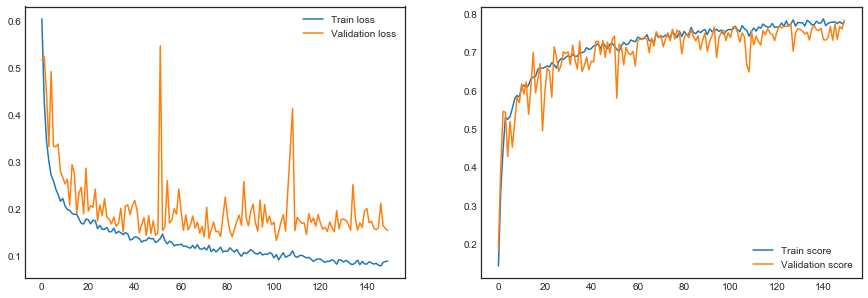

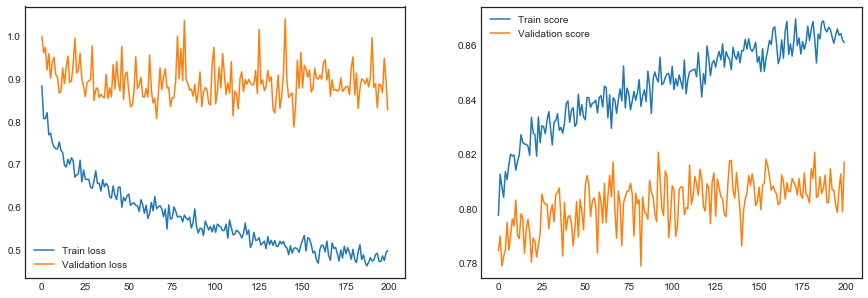

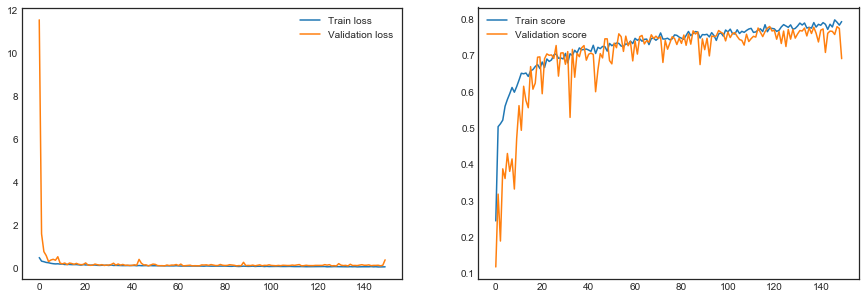

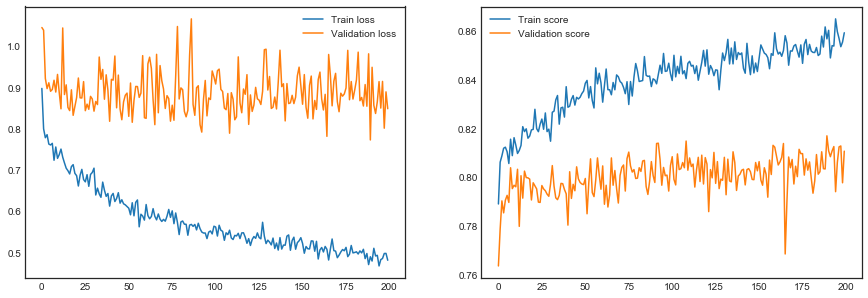

In [71]:
# training cv=[4,5]
t_start = time.time()

for cv_index in range(3,cv_total):
    print(cv_index)
    t1 = time.time()
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    #save_model_name_prev = f'Unet_resnet_v36_cv{cv_index+1}' + '.model'
    #print(save_model_name_prev)

    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    #---------------- Step 1 - BCE -------------------------
    save_model_name = basic_name + '_Step1a.model'
    print(save_model_name)
    
    #model = load_model(save_model_name_prev,custom_objects={'my_iou_metric': my_iou_metric})
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.5)
    model = Model(input_layer, output_layer)
    
    c = optimizers.adam(lr = 0.001)
    model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    #model.load_weights(save_model_name_prev)

    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max',save_best_only=True, verbose=1)
    #reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',
    #                               factor=0.5, patience=25, min_lr=0.0001, verbose=1)

    epochs = 150  
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] #,reduce_lr
                             )
    plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)    
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious[cv_index] = get_iou_vector(np.squeeze(y_valid), np.squeeze(preds_valid > 0.5))
    print(f"cv {cv_index} ious = {ious[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
    #---------------- Step 2 - LL -------------------------
    input_x = model.layers[0].input
    output_layer = model.layers[-1].input #need to cancel last sigmoid activation for Lovasz Loss
    model = Model(input_x, output_layer)
    c = optimizers.adam(lr = 0.0005)
    
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    model.load_weights(save_model_name)
    
    save_model_name=basic_name + '_Step2a.model'
    print(save_model_name)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2',
                                       mode = 'max', save_best_only=True, verbose=1)
    
    epochs = 200
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history2 = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] 
                             )
    plot_history(history2,'my_iou_metric_2')
    
    model.load_weights(save_model_name)
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious2[cv_index] = get_iou_vector(np.squeeze(y_valid),np.squeeze(preds_valid > 0.0))
    print(f"cv {cv_index} ious2 = {ious2[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
t_end = time.time()
print(f"Usedtime = {t_end-t_start} s")

In [72]:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")
    
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious2 = {ious2[cv_index]}")

cv 0 ious = 0.7885286783042393
cv 1 ious = 0.8121098626716604
cv 2 ious = 0.8084893882646691
cv 3 ious = 0.78375
cv 4 ious = 0.7854271356783921
cv 0 ious2 = 0.8200748129675811
cv 1 ious2 = 0.8337078651685392
cv 2 ious2 = 0.8294631710362048
cv 3 ious2 = 0.8195
cv 4 ious2 = 0.8266331658291457


In [73]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total): #cv_total
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '_Step2a.model')
    preds_test += (predict_result(model,x_test,img_size_target)) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 487.0887324810028 s


In [74]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 13.894025325775146 s


In [75]:
# create file for Kaggle submission
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(basic_name + 'Step2a_CV=5.csv')

## ----- Step 3: One more round of Lovasz loss for all 5 folds -------------------------

In [76]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip
    iaa.OneOf([
        iaa.Noop(),
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Noop(),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.Noop(),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
        iaa.Noop(),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.02*255)),
        iaa.Noop(),
        iaa.Multiply((0.8, 1.2)),
        iaa.Noop(),
        iaa.Add((-25, 25)),
        iaa.Noop(),
        iaa.Affine(rotate=(-10, 10),translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0)),
        iaa.Noop(),
        iaa.CropAndPad(percent=(-0.15, 0.15),pad_mode=ia.ALL,pad_cval=(0, 255))
    ]),    
    # More as you want ...
],random_order=True)
seq_det = seq.to_deterministic()

In [ ]:
ious3 = [0] * cv_total

# training cv=[1-5]
t_start = time.time()

for cv_index in range(cv_total):
    print(cv_index)
    t1 = time.time()
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    #Data augmentation
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    save_model_name = basic_name + '_Step2a.model'
    print(save_model_name)
    
    c = optimizers.adam(lr = 0.0001)
    
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    model.load_weights(save_model_name)
    
    save_model_name=basic_name + '_Step3a.model'
    print(save_model_name)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2',
                                       mode = 'max', save_best_only=True, verbose=1)
    
    epochs = 25
    batch_size = 128
    steps_per_epoch=round(x_train.shape[0]/batch_size)
    history2 = model.fit_generator(generator(x_train, y_train, batch_size, seq),
                              epochs=epochs, 
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              verbose = 2, 
                              callbacks = [model_checkpoint] 
                             )
    plot_history(history2,'my_iou_metric_2')
    
    model.load_weights(save_model_name)
    preds_valid = predict_result(model,x_valid,img_size_target)
    ious3[cv_index] = get_iou_vector(np.squeeze(y_valid),np.squeeze(preds_valid > 0.0))
    print(f"cv {cv_index} ious3 = {ious3[cv_index]}")
    
    t2 = time.time()
    print(f"Usedtime = {t2-t1} s")
    
t_end = time.time()
print(f"Usedtime = {t_end-t_start} s")

In [78]:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious3 = {ious3[cv_index]}")

cv 0 ious3 = 0.816708229426434
cv 1 ious3 = 0.8307116104868913
cv 2 ious3 = 0.8337078651685392
cv 3 ious3 = 0.81025
cv 4 ious3 = 0.8212311557788945


In [79]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total): #cv_total
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '_Step3a.model')
    preds_test += (predict_result(model,x_test,img_size_target)) /cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 346.3486416339874 s


In [80]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 13.959527492523193 s


In [81]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(basic_name + 'Step3a_CV=5.csv')

In [25]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [59]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(1): #cv_total
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    model.load_weights(basic_name + '_Step2a.model')
    preds_test += (predict_result(model,x_test,img_size_target)) /1. #cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Usedtime = 106.53966927528381 s


In [60]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 10.57349705696106 s


In [61]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(basic_name + 'Step2a_CV=1.csv')

## -------- Average folds from different models for Kaggle submission ("hacky") ----------

## Average 2 folds from Model 4.0 with agressive augmentation 

In [53]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(2): #cv_total
    basic_name = f'Unet_resnet_v{version}_cv{cv_index+1}'
    print(basic_name+ '_Step3.model')
    model = load_model(basic_name + '_Step3.model',custom_objects={'my_iou_metric_2': my_iou_metric_2,'lovasz_loss':lovasz_loss})
    preds_test += (predict_result(model,x_test,img_size_target)) /2. #cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

Unet_resnet_v40_cv1_Step3.model
Unet_resnet_v40_cv2_Step3.model
Usedtime = 315.8169593811035 s


In [54]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 9.012247800827026 s


In [55]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(basic_name + 'Step3_CV=2.csv')

## Average folds from Model 3.6

In [57]:
# Unet_resnet_v36_cv9_Step3d_Step3b.csv
fileNames=np.array(['../Model3-6/Unet_resnet_v36_cv1_Step3d.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv5_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv1_Step2b.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step2b.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step2b.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step2b.model',
                    'Unet_resnet_v40_cv1_Step3a.model',
                    'Unet_resnet_v40_cv2_Step3a.model',
                    'Unet_resnet_v40_cv3_Step3a.model',
                    'Unet_resnet_v40_cv4_Step3a.model',
                    'Unet_resnet_v40_cv5_Step3a.model',
                    'Unet_resnet_v3_cv1_Step3_Vyatkin.model'
                   ])

In [65]:
# Unet_resnet_cv7_v36_Step3d_cv5_v40_Step3_cv2.csv
fileNames=np.array(['../Model3-6/Unet_resnet_v36_cv1_Step3d.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv5_Step3d.model',
                    'Unet_resnet_v40_cv1_Step3.model',
                    'Unet_resnet_v40_cv2_Step3.model'
                   ])

In [ ]:
                    '../Model3-6/Unet_resnet_v36_cv1_Step2c.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step2c.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step2c.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step2c.model',
                    '../Model3-6/Unet_resnet_v36_cv5_Step2c.model',

In [82]:
#6
fileNames=np.array(['Unet_resnet_v40_cv1_Step3a.model',
                    'Unet_resnet_v40_cv2_Step3a.model',
                    'Unet_resnet_v40_cv3_Step3a.model',
                    'Unet_resnet_v40_cv4_Step3a.model',
                    'Unet_resnet_v40_cv5_Step3a.model',
                    'Unet_resnet_v3_cv1_Step3_Vyatkin.model'
                   ])

In [98]:
fileNames=np.array(['../Model3-6/Unet_resnet_v36_cv1_Step3d.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv5_Step3d.model',
                    'Unet_resnet_v40_cv1_Step3a.model',
                    'Unet_resnet_v40_cv2_Step3a.model',
                    'Unet_resnet_v40_cv3_Step3a.model',
                    'Unet_resnet_v40_cv4_Step3a.model',
                    'Unet_resnet_v40_cv5_Step3a.model'
                   ])

In [99]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(10): #cv_total
    print(fileNames[cv_index])
    #model = load_model(fileNames[cv_index],custom_objects={'my_iou_metric_2': my_iou_metric_2,'lovasz_loss':lovasz_loss})
    model.load_weights(fileNames[cv_index])
    preds_test += (predict_result(model,x_test,img_size_target)) /10. #cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

../Model3-6/Unet_resnet_v36_cv1_Step3d.model
../Model3-6/Unet_resnet_v36_cv2_Step3d.model
../Model3-6/Unet_resnet_v36_cv3_Step3d.model
../Model3-6/Unet_resnet_v36_cv4_Step3d.model
../Model3-6/Unet_resnet_v36_cv5_Step3d.model
Unet_resnet_v40_cv1_Step3a.model
Unet_resnet_v40_cv2_Step3a.model
Unet_resnet_v40_cv3_Step3a.model
Unet_resnet_v40_cv4_Step3a.model
Unet_resnet_v40_cv5_Step3a.model
Usedtime = 669.88440990448 s


In [100]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 9.674264907836914 s


In [101]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
#sub.to_csv('Unet_resnet_v36_cv9_Step3d_Step3b.csv')
#sub.to_csv('Unet_resnet_cv5_Best3.csv')
sub.to_csv('Unet_resnet_cv11_v40_Step3a_v36_Step3d.csv')

In [86]:
#11
fileNames=np.array(['../Model3-6/Unet_resnet_v36_cv1_Step3d.model', 
                    '../Model3-6/Unet_resnet_v36_cv2_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv3_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv4_Step3d.model',
                    '../Model3-6/Unet_resnet_v36_cv5_Step3d.model',
                    'Unet_resnet_v40_cv1_Step3a.model',
                    'Unet_resnet_v40_cv2_Step3a.model',
                    'Unet_resnet_v40_cv3_Step3a.model',
                    'Unet_resnet_v40_cv4_Step3a.model',
                    'Unet_resnet_v40_cv5_Step3a.model',
                    'Unet_resnet_v3_cv1_Step3_Vyatkin.model'
                   ])

In [87]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(11): #cv_total
    print(fileNames[cv_index])
    #model = load_model(fileNames[cv_index],custom_objects={'my_iou_metric_2': my_iou_metric_2,'lovasz_loss':lovasz_loss})
    model.load_weights(fileNames[cv_index])
    preds_test += (predict_result(model,x_test,img_size_target)) /11. #cv_total
    
t2 = time.time()
print(f"Usedtime = {t2-t1} s")

../Model3-6/Unet_resnet_v36_cv1_Step3d.model
../Model3-6/Unet_resnet_v36_cv2_Step3d.model
../Model3-6/Unet_resnet_v36_cv3_Step3d.model
../Model3-6/Unet_resnet_v36_cv4_Step3d.model
../Model3-6/Unet_resnet_v36_cv5_Step3d.model
Unet_resnet_v40_cv1_Step3a.model
Unet_resnet_v40_cv2_Step3a.model
Unet_resnet_v40_cv3_Step3a.model
Unet_resnet_v40_cv4_Step3a.model
Unet_resnet_v40_cv5_Step3a.model
Unet_resnet_v3_cv1_Step3_Vyatkin.model
Usedtime = 743.3116652965546 s


In [88]:
t1 = time.time()
threshold  = 0.0
pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 9.644307851791382 s


In [89]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
#sub.to_csv('Unet_resnet_v36_cv9_Step3d_Step3b.csv')
sub.to_csv('Unet_resnet_cv11_v40_Step3a_v36_Step3d_andSV.csv')